# Mixed Data Features

In previous lectures, we've used neural networks to perform "basic" classification, image classification, and text classification. In each of these, we used a single pipeline that we custom built for the data we needed to work with, usually enclosed within a `keras.models.Sequential()` model. This worked fine for those situations, but what happens when we have *multiple* complex data components that we would like to use in our models? For example, maybe we would like to do classification in a dataset containing both: 

1. Pictures (images) and captions (text). 
2. Descriptions (text) and timestamps (numbers). 
3. Article bodies (text) and titles (different text). 

Of course, it's possible to come up with various ad hoc ways to smoosh pieces of data together, but this isn't usually the right approach. A better thing to do is to create a more flexible model that accepts and appropriately processes different kinds of inputs. In this lecture, we'll learn how to do this. 

### Key Tools

- Labeled data sets. 
- The Keras functional API (alternative to Sequential API). 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

# requires update to tensorflow 2.4
# >>> conda activate PIC16B
# >>> pip install tensorflow==2.4
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

In [1]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


Our data set for this lecture contains various information about various musical tracks produced between the years 1950 and 2019. You can find it on Kaggle [here](https://www.kaggle.com/saurabhshahane/music-dataset-1950-to-2019). The data was originally published in the following data publication: 

> Moura, Luan; Fontelles, Emanuel; Sampaio, Vinicius; França, Mardônio (2020), “Music Dataset: Lyrics and Metadata from 1950 to 2019”, Mendeley Data, V3, doi: 10.17632/3t9vbwxgr5.3

In [2]:
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)

Let's take a quick look: 

In [3]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


We have a number of columns here! We'll focus on a few subsets in particular: 

The `genre` describes the overall genre of the track. It has seven values: 

genre
blues      4604
country    5445
hip hop     904
jazz       3845
pop        7042
reggae     2498
rock       4034
dtype: int64

There data also includes 
- The complete `lyrics` of the track (if it has any) 
- The normalized `age` of the track (1.0 corresponds to tracks released in 1950, 0.0 corresponds to more recent tracks)
- A selection of columns that give the track numerical scores reflecting various attributes and topics, such as "danceability," "loudness," and "acousticness." 

There are also other columns in the data, but these are the ones we're going to focus on for this analysis. We are going to subset things a bit: let's focus on only a few genres, and on only relatively recent tracks. 

Next, let's do a categorical encoding of the `genre` column. 

## Create a Dataset

We're now ready to create a TensorFlow `Dataset`. This is going to be a little more involved than last time, because we need to distinguish between different kinds of model inputs. 

Here's a list of all the scalar "score" columns in the data frame. 

In [6]:
scalars = ['dating', 
           'violence', 
           'world/life', 
           'night/time',
           'shake the audience',
           'family/gospel', 
           'romantic', 
           'communication',
           'obscene', 
           'music', 
           'movement/places', 
           'light/visual perceptions',
           'family/spiritual', 
           'like/girls', 
           'sadness', 
           'feelings', 
           'danceability',
           'loudness', 
           'acousticness', 
           'instrumentalness', 
           'valence', 
           'energy']        

Because we have multiple inputs, we are going to construct our `Dataset` from a tuple of dictionaries. The first dictionary is going to specify the different components in the predictor data, while the second dictionary is going to specify the different components of the target data. 

Next, we are going to perform a train/test/validation split. For each of the three split `Datasets`, we are going to *batch* them into small chunks of data. This helps with training runtime later. 

(134, 19, 39)

Each of the numbers above should be multipled by the batch size to give the total number of rows in each `Dataset`. 

The code below sets up exactly the same text preprocessing that we did [last lecture](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16B/blob/master/lectures/tf/tf-3.ipynb). 

## The Keras Functional API

In previousl lectures, we used the `Sequential` API for constructing models. For example, we wrote code like this: 

```python
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 3),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(len(categories))]
)
```

This model is designed to accept a single kind of input (in this case text) and spit out a single output. However, in our case we have two distinct *kinds* of input: the song lyrics and the scalar scores. It wouldn't really make much sense to pass the scalar scores through a text vectorization or embedding layer. For this reason, we need to move beyond the `Sequential` API and instead constructing our models using a somewhat more manual approach, referred to as the `Functional` API. 

### Inputs

Start by specifying the two kinds of `keras.Input` for our model. You should have one input for each qualitatively distinct "kind" of predictor data. All the parameters here are important: 

- `shape` should describe the shape of a single item of data. For example, the `lyrics` column contains just one entry for each song, so the shape is `(1,)` (a tuple of length 1). On the other hand, there are `len(scalars) = 22` distinct columns of scalar scores. 
- the `name` should be some descriptive name that you're able to remember for later. 
- The `dtype` specifies the kind of data contained in each of the input tensors. 

In [10]:
# inputs


<KerasTensor: shape=(None, 1) dtype=string (created by layer 'lyrics')>

## Hidden Layers

First, let's write a pipeline for the lyrics. This pipeline is pretty much the same as the one we used earlier for text classification -- we're just building it differently. 

In [11]:
# layers for processing the lyrics, pretty much the same as from our lecture
# on text classification


Next, let's write a pipeline for the scalars. We don't need to do anything fancy with them, so instead of messing with `Embeddings` and the like, we're just going to pass them through a `Dense` layer. 

Here's simultaneously the most important and most boring part of the whole model: we are going to `concatenate` the output of the `lyrics` pipeline with the output of the `scalar` pipeline: 

Finally, let's pass the consolidated set of computed features through a few more `Dense` layers. Remember that the very last `Dense` layer should have a number of outputs equal to the number of classes in the data. 

**Observe that the output layer has a name, and that this name matches the key corresponding to the target data in the `Datasets` we will pass to the model.** This is how TensorFlow knows which part of our data set to compare against the outputs! 

So far, we haven't actually created a model yet -- just a bunch of interrelated layers. We create the model by specifying the input(s) and output. 

The model summary provides one good way to look at the structure of the model, but it can be difficult to read when there are multiple inputs: 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lyrics (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 500)          0           lyrics[0][0]                     
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 3)       6000        text_vectorization[0][0]         
__________________________________________________________________________________________________
dropout (Dropout)               (None, 500, 3)       0           embedding[0][0]                  
______________________________________________________________________________________________

Something a bit more visually attractive can be obtained by using the `plot_model` function: 

In [17]:
keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Now we're ready to train and evaluate our model as usual! As always, we need to compile:

And now we train! 

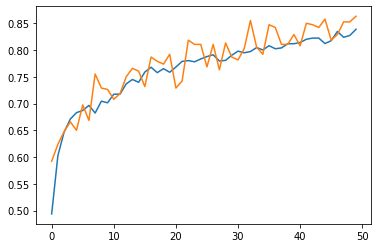